<h2>
# Movies Classification Project
</center></h4> <h4>
 <img src="http://usblogs.pwc.com/emerging-technology/wp-content/uploads/2017/07/deep-learning-900x280.png" >


# Deep Learning Text

</h4>

Developed by [Sergio Castelblanco](http://www.linkedin.com/in/sergio-castelblanco/) - [Jesus Solano](http://www.jesussolano.com)

Andes University

version 2.1, July 9 2018

In [0]:
# Import needed libraries. 

import pandas as pd
import os
import numpy as np
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from skimage import io
from tqdm import tqdm
import os
%matplotlib inline

In [0]:
# If datasets already exist do nothing. 


if not os.path.exists('dataTesting.csv'):
  ! wget https://raw.githubusercontent.com/castellwhite/MoviesClassification/master/datasets/dataTesting.csv
    
if not os.path.exists('dataTraining.csv'):
  ! wget https://raw.githubusercontent.com/castellwhite/MoviesClassification/master/datasets/dataTraining.csv
    
dataTraining = pd.read_csv("dataTraining.csv",index_col=0)
dataTesting = pd.read_csv("dataTesting.csv",index_col=0)

# Read Data

In [0]:
# Creates dataframes for images indices.

dataTraining = pd.read_csv("dataTraining.csv",index_col=0)
dataTesting = pd.read_csv("dataTesting.csv",index_col=0)

In [5]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [6]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


# Pre-process Text

### Word 2 Vec Approach

In [0]:
# Load functions and prerrequisites of word2vec.



import tensorflow_hub as hub
import tensorflow as tf
import numpy as np


hub_model = "https://tfhub.dev/google/Wiki-words-250/1"


def create_text_embedding(hub_model, input_sentences):
        
    SEQ_LENGTH = max(map(len, input_sentences))
    EMBEDDING_DIM = 250

    with tf.Graph().as_default() as g:

        embed_layer = hub.Module(hub_model,
        trainable=False, name='text_embedding')

        sentences = tf.placeholder(dtype=tf.string, shape=(None, SEQ_LENGTH))
        batch_size = tf.shape(sentences)[0]

        flat_sentences = tf.reshape(sentences, [-1])

        embeddings = embed_layer(flat_sentences)

        sentence_embedding = tf.reshape(embeddings, 
                                      [batch_size, SEQ_LENGTH, EMBEDDING_DIM])

        with tf.Session(graph=g) as sess:
            sess.run(tf.global_variables_initializer())
            sess.run(tf.tables_initializer())

            output = sess.run(sentence_embedding, feed_dict={
                sentences: input_sentences
            })
            
    return output

In [0]:
# Get plots and lables for each plot.

xPlot=dataTraining['plot']
xPlotTest = dataTesting['plot']

dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
yGenres = le.fit_transform(dataTraining['genres'])

In [9]:
# Converts a text to a sequence of words (or tokens)

from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences


maxWords = 300

xTokenTrain = [text_to_word_sequence(x) for x in xPlot.tolist()]
xTokenTrain = pad_sequences(xTokenTrain, dtype='str', value=0, maxlen=maxWords)

xTokenTest = [text_to_word_sequence(x) for x in xPlotTest.tolist()]
xTokenTest = pad_sequences(xTokenTest, dtype='str', value=0, maxlen=maxWords)

xTokenTrain.shape

Using TensorFlow backend.


(7895, 300)

In [10]:
# Apply Word2Vec

xEmbeddingTrain = create_text_embedding(hub_model, xTokenTrain)

xEmbeddingTrain.shape

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Initialize variable text_embedding/embeddings/part_0:0,text_embedding/embeddings/part_1:0 from checkpoint b'/tmp/tfhub_modules/1e7e72950396d90315d3d9c57eddf5da44d4dca2/variables/variables' with embeddings


(7895, 300, 250)

In [11]:
# Apply Word2Vec

xEmbeddingTest = create_text_embedding(hub_model, xTokenTest)

xEmbeddingTest.shape



INFO:tensorflow:Initialize variable text_embedding/embeddings/part_0:0,text_embedding/embeddings/part_1:0 from checkpoint b'/tmp/tfhub_modules/1e7e72950396d90315d3d9c57eddf5da44d4dca2/variables/variables' with embeddings


(3383, 300, 250)

In [12]:
# Creates datasets for training and testing.   
xTrainTxt, xValidationTxt, yTrainTxt, yValidationTxt = train_test_split(xEmbeddingTrain, yGenres, test_size=0.20, random_state=22)
xTrainTxt.shape

(6316, 300, 250)

# Neural Network

In [0]:
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Flatten, Dropout, Activation, BatchNormalization
from keras import optimizers as opts
from keras.callbacks import History
from keras.layers import Conv1D, GlobalMaxPooling1D
from livelossplot import PlotLossesKeras
from google.colab import files

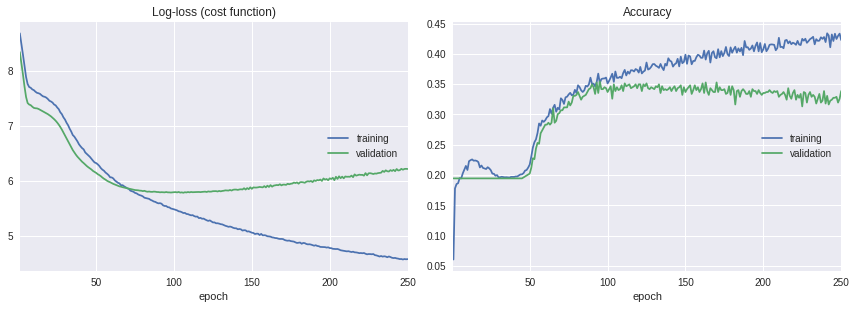

In [14]:
from keras import backend as K
K.clear_session()

outputClasses= 24

modelTxt = Sequential()
modelTxt.add(Conv1D(100, 2, padding='same', strides=1, input_shape=xTrainTxt.shape[1:]))
modelTxt.add(Activation('relu'))
modelTxt.add(GlobalMaxPooling1D())

modelTxt.add(Dense(256))
modelTxt.add(Activation('relu'))
modelTxt.add(Dropout(0.5))
modelTxt.add(Dense(outputClasses))
modelTxt.add(Activation('sigmoid'))

print(modelTxt.summary(70))

# Compile the model. 

op = opts.Adam(lr=0.001)

modelTxt.compile(loss = 'categorical_crossentropy',
              optimizer = op,
              metrics = ['accuracy'])

batch_size = 2000
epochs = 250

modelTxt.fit(xTrainTxt, yTrainTxt,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle = True, 
                    validation_split = 0.1,
                    callbacks=[PlotLossesKeras()])

modelTxt.save('txtWord2Vec.h5')

files.download('txtWord2Vec.h5')


In [15]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

yPredGenreTxt = modelTxt.predict(xValidationTxt)
txtAUC = roc_auc_score(yValidationTxt, yPredGenreTxt, average='macro')
# Perform the neural network over the test set. 

print('Evaluating the test set...')
score = modelTxt.evaluate(xValidationTxt, yValidationTxt)
#roc_curve(yValidationTxt,yPredGenre)

print('\nTest score:', score[0])
print('Test accuracy:', score[1])
print('Model AUC is: ', txtAUC )

Evaluating the test set...
1579/1579 [==============================] - 0s 265us/step

Test score: 6.108060539033007
Test accuracy: 0.3470550982577654
Model AUC is:  0.8716092117245041


# Apply models to test

In [0]:
# Print prediction for test (kaggle) data. 

yPredTest = modelTxt.predict_proba(xEmbeddingTest)

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

pd.DataFrame(yPredTest, index=dataTesting.index, columns=cols).to_csv('pred_genres_word2vec_TXT_2.csv', index_label='ID')



In [0]:
from google.colab import files

files.download('pred_genres_word2vec_TXT_2.csv')

In [17]:
!pip3 install -U -q tqdm
!pip3 install -U -q livelossplot

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [20]:
! ls

datalab		 dataTraining.csv	       txtWord2Vec.h5
dataTesting.csv  pred_genres_word2vec_TXT.csv
